In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
from random import random
import sys
print(sys.version)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


Testing the learning curve mathematics based on three parameters.


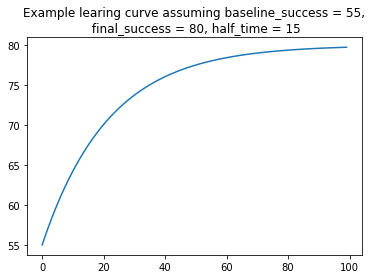

In [102]:
print("Testing the learning curve mathematics based on three parameters.")

def success_p(attempt, baseline_success, final_success, half_time):
    failure_risk = 0.5**(attempt/half_time) # in range 0 to 1
    return final_success - failure_risk *(final_success - baseline_success)

baseline_success = 55 # percent
final_success = 80 # percent
half_time = 15 # cases

x = np.array(range(0, 100))  
y = success_p(attempt = x, baseline_success = baseline_success, final_success = final_success, half_time = half_time)
plt.plot(x, y)  
plt.title(f"Example learing curve assuming baseline_success = {baseline_success},\n final_success = {final_success}, half_time = {half_time}")
plt.show()  



baseline_success_p = 0.69 (sd: 0.19)
final_success_p = 0.84 (sd: 0.14)
attempts_to_half_improvement = 6.34 (sd: 3.28)



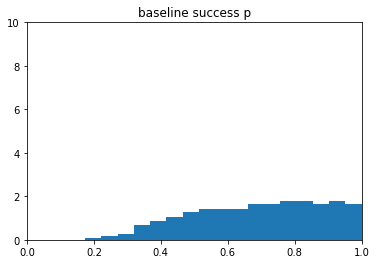

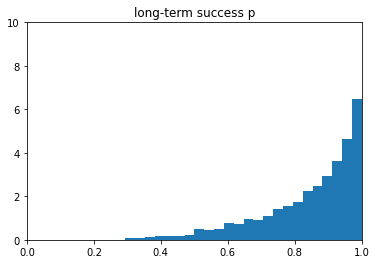

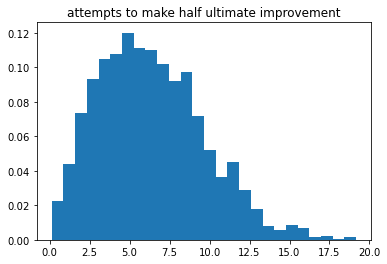

In [3]:
##
## Create a population of learning curves
## (as three seperate arrays of the defining parameters)
## 
n = 2000
odds_of_failure = 0.6
fall_in_failure_rate = 1
half_time_mean = 5
baseline_success_p = 1/(1+np.random.exponential(odds_of_failure,n))
final_success_p = 1- ((1-baseline_success_p) * fall_in_failure_rate*np.random.random(n))
attempts_to_half_improvement = np.random.rayleigh(half_time_mean,n)

print(f"""
baseline_success_p = {baseline_success_p.mean():0.2f} (sd: {baseline_success_p.std():0.2f})
final_success_p = {final_success_p.mean():0.2f} (sd: {final_success_p.std():0.2f})
attempts_to_half_improvement = {attempts_to_half_improvement.mean():0.2f} (sd: {attempts_to_half_improvement.std():0.2f})
""")

count, bins, ignored = plt.hist(baseline_success_p, bins="auto", density=True)
plt.axis((0,1,0,n/200))
plt.title("baseline success p")
plt.show()

count, bins, ignored = plt.hist(final_success_p, bins="auto", density=True, range=(0,1))
plt.title("long-term success p")
plt.axis((0,1,0,n/200))
plt.show()

count, bins, ignored = plt.hist(attempts_to_half_improvement, bins="auto", density=True)
plt.title("attempts to make half ultimate improvement")
plt.show()

def student_p(student_id, attempt):
    failure_risk = 0.5**(attempt/attempts_to_half_improvement[student_id]) # in range 0 to 1
    return final_success_p[student_id] - failure_risk *(final_success_p[student_id] - baseline_success_p[student_id])


In [4]:
# create a 2d array of student success probabilities
students = np.array(range(0, n))
attempts = np.array(range(0, 20))
student_attempt_success = student_p(students[:,np.newaxis],attempts[np.newaxis,:])


In [83]:
def succeeded(p, success_relative_increase):
    random_roll = np.random.random(p.shape)
    modified_success = 1 - ((1-p)/(1+success_relative_increase))
    pp(7, f"P initial: {p.mean():0.3}  P after adjustment: {modified_success.mean():0.3}; dice: {random_roll.mean():0.3}")
    return random_roll < modified_success

subject_n = 50
attempt_n = 20
#subject_n, attempt_n
#[:subject_n, :attempt_n]
trials = 1000
verbosity = 10 if trials < 3 else 6 if trials < 10 else 2  # range of 0-10
print(f"verbosity: {verbosity}")
def pp(importance, message):
    if importance > 10-verbosity:
        print(message)

attempt_data = []
participant_data = []
trial_data = []
        
print(f"{trials} trials sampling {subject_n} per group out of {student_attempt_success.shape[0]} students, each having {attempt_n} attempts")
groups = {"control": 0, "intervention":0.4}
totals = {"control": 0, "intervention":0}
attempts_per_group = trials*subject_n*attempt_n
print(f"{attempts_per_group} total attempts per group")
for trial in range(trials):
    pp(7,f"=======\ntrial {trial}")
    for group, success_relative_increase in groups.items():
        pp(6, f"group: {group}")
        students = student_attempt_success[np.random.choice(len(students), subject_n, replace=True), :attempt_n]
        pp(5,students)
        result = succeeded(students,success_relative_increase)
        pp(6, f"result: {result}")
        pp(6, f"{group} success: {result.sum()}/{(result.size)} ({100*result.sum()/(result.size):3.1f}%)" )
        totals[group] += result.sum()
        rec = {'trial': trial, 'group': group, "result": result.sum()}
        trial_data.append(rec)
        for p in range(subject_n):
            participant_results = result[p]
            rec["p"] = f"{group}{p}"
            prec = {**rec, "result": participant_results.sum()}
            pp(1,prec)
            participant_data.append(prec)
            for i in range(len(participant_results)):
                irec = {**rec, "i": i, "result": 1 if participant_results[i] else 0}
                pp(1,irec)
                attempt_data.append(irec)
        
print(f"totals: {totals}")
td = pd.DataFrame(trial_data)
partd = pd.DataFrame(participant_data)
ad = pd.DataFrame(attempt_data)

verbosity: 2
1000 trials sampling 50 per group out of 2000 students, each having 20 attempts
1000000 total attempts per group
totals: {'control': 767786, 'intervention': 832701}


In [84]:
# calculate success rates
results_percents = {}
for group, result in totals.items():
    print(group, result)
    results_percents[group] = 100*result/attempts_per_group

results_percents

control 767786
intervention 832701


{'control': 76.7786, 'intervention': 83.2701}

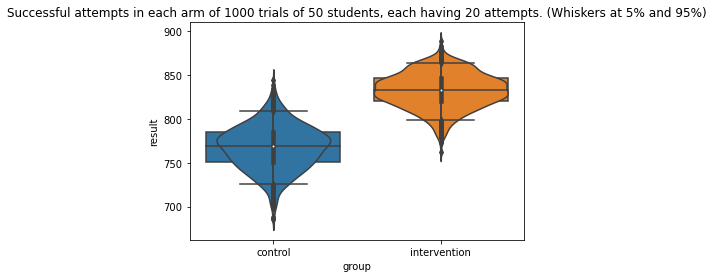

In [97]:
import seaborn as sns
whisker = 5
ax = sns.boxplot(x="group", y="result", data=td, whis=[whisker, 100-whisker])
#ax = sns.swarmplot(x="group", y="result", data=td)
ax = sns.violinplot(x="group", y="result", data=td)

plt.title(f"Successful attempts in each arm of {trials} trials of {subject_n} students, each having {attempt_n} attempts. (Whiskers at {whisker}% and {100-whisker}%)")
plt.show()

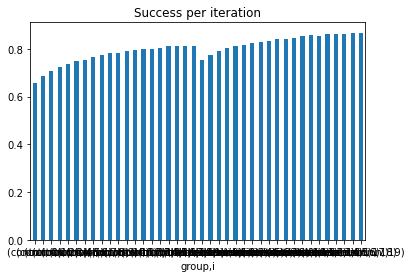

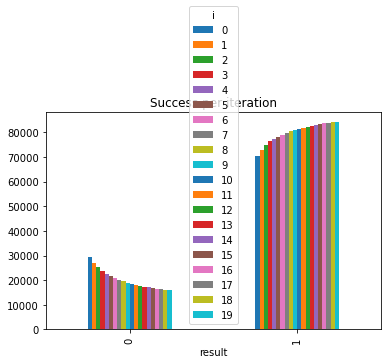

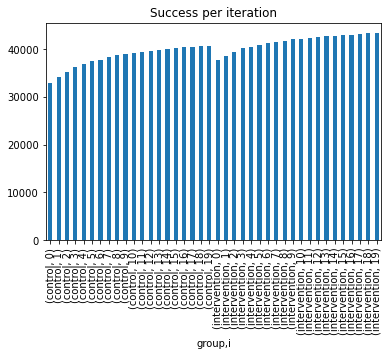

In [133]:
"""
# can't get this to work
lcpd = ad.groupby(by=['group','i'])
fig, ax = plt.subplots()
lcpd.mean().result.plot.bar(ax=ax, capsize=4, rot=0)
plt.title("Success per iteration")
plt.show()
"""



pd.crosstab(ad.result, ad.i).plot(kind='bar')
plt.title("Success per iteration")
plt.show()

ad.groupby(['group', 'i']).result.sum().plot(stacked=True,kind='bar')
plt.title("Success per iteration")
plt.show()



In [134]:
print("Attempt level data for a single tri")
ad.query("trial == 5")

Attempt level data for a single tri


,trial,group,result,p,i
10000,5,control,0,control0,0
10001,5,control,1,control0,1
10002,5,control,1,control0,2
10003,5,control,1,control0,3
10004,5,control,1,control0,4
...,...,...,...,...,...
11995,5,intervention,1,intervention49,15
11996,5,intervention,1,intervention49,16
11997,5,intervention,1,intervention49,17
11998,5,intervention,1,intervention49,18


In [182]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.formula.api import gee



tests = ['geeBIs','geeBI'] #,'gee', 'ols', 'geeB']
outcomes = {}
random_start = 8
trials_to_test = range(random_start,random_start+4)

trials_to_test = range(trials) 

verbosity = 6 if len(trials_to_test) < 5 else 4
def evaulate_test(ad):
    for trial in trials_to_test:
        pp(5, f"#### trial: {trial} #####")
        itd = ad.query(f"trial == {trial}") # individual trial data
        c = itd[['group','result']].groupby("group").sum().reset_index().set_index("group")
        for model in tests:
            pp(5, f"#### {model}")
            if model == 'ols':
                res = ols('result ~ C(group)+i', data=itd).fit()
            if model == 'geeB':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            if model == 'geeBI':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            if model == 'geeBIs': # drop the "i" variable (which tracks attempt number)
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()

            if model == 'gee':
                fam = sm.families.Poisson()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            pp(3, res.summary())
            p=res.pvalues[1]
            outcome = 'wrong' if c['result'][0] > c['result'][1] else 'insign' if p > 0.05 else 'sig' if p> 0.01 else 'vsig'
            pp(6, f"******************p = {p:0.6f} -{outcome}")
            outcomes[model] = outcomes.get(model,{'wrong':0,'insign':0,'sig':0,'vsig':0})
            outcomes[model][outcome] = 1 + outcomes[model].get(outcome, 0)

    return(outcomes)


"""
{'gee': {'sig': 228, 'vsig': 291, 'insign': 464, 'wrong': 17},
 'ols': {'vsig': 719, 'sig': 108, 'insign': 156, 'wrong': 17},
 'geeB': {'sig': 225, 'vsig': 329, 'insign': 429, 'wrong': 17}}
{'geeBI': {'wrong': 17, 'insign': 446, 'sig': 214, 'vsig': 323}}
'geeBIs': {'wrong': 17, 'insign': 446, 'sig': 215, 'vsig': 322}

"""
        
evaulate_test(ad)

{'geeBIs': {'wrong': 17, 'insign': 446, 'sig': 215, 'vsig': 322},
 'geeBI': {'wrong': 17, 'insign': 446, 'sig': 214, 'vsig': 323}}

In [145]:
ad.head(20)

,trial,group,result,p,i
0,0,control,1,control0,0
1,0,control,0,control0,1
2,0,control,1,control0,2
3,0,control,1,control0,3
4,0,control,1,control0,4
5,0,control,1,control0,5
6,0,control,1,control0,6
7,0,control,1,control0,7
8,0,control,1,control0,8
9,0,control,1,control0,9


In [142]:
data = sm.datasets.get_rdataset('epil', package='MASS').data

In [144]:
data.head(20)

,y,trt,base,age,V4,subject,period,lbase,lage
0,5,placebo,11,31,0,1,1,-0.756354,0.114204
1,3,placebo,11,31,0,1,2,-0.756354,0.114204
2,3,placebo,11,31,0,1,3,-0.756354,0.114204
3,3,placebo,11,31,1,1,4,-0.756354,0.114204
4,3,placebo,11,30,0,2,1,-0.756354,0.081414
5,5,placebo,11,30,0,2,2,-0.756354,0.081414
6,3,placebo,11,30,0,2,3,-0.756354,0.081414
7,3,placebo,11,30,1,2,4,-0.756354,0.081414
8,2,placebo,6,25,0,3,1,-1.362490,-0.100908
9,4,placebo,6,25,0,3,2,-1.362490,-0.100908
